## Adaptation of Gluon's Self-attentive Sentence Embedding

#### Eryk Wdowiak and Eric Adsetts

we are adapting [Gluon tutorial](https://gluon-nlp.mxnet.io/examples/sentence_embedding/self_attentive_sentence_embedding.html)

In [1]:
import itertools
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import mxnet as mx
import multiprocessing as mp
import gluonnlp as nlp

from mxnet import gluon, nd, init
from mxnet.gluon import nn, rnn
from mxnet import autograd, gluon, nd

# fixed random number seed
np.random.seed(2018)
mx.random.seed(2018)

### preliminary data processing

In [2]:
##  load data
data = pd.read_csv('dataset/judge-1377884607_tweet_product_company_v2-clean.csv')
data.columns = ['tweet','direction','emotion']
# data.shape  # (9093, 3)

##  remove rows without tweet
data = data.dropna(subset=['tweet','emotion'],axis='index')
# data.shape  # (9092, 3)

##  clean emotions
emo_dict = {'Negative emotion':'negative', 
            'Positive emotion':'positive',
            'No emotion toward brand or product':'neutral', 
            "I can't tell":'neutral'}
data['emotion'] = data['emotion'].replace(emo_dict)
del emo_dict

emo_int_dict = {'negative':0, 'neutral':1, 'positive':2 } 
data['emot_int'] = data['emotion'].replace(emo_int_dict)
del emo_int_dict

##  define company and product
##  first convert NaN to a string
data['direction'] = data['direction'].map('{}'.format)

##  define company
comp_dict = {'iPhone':'Apple', 
             'iPad or iPhone App':'Apple', 
             'iPad':'Apple', 
             'Google':'Google', 
             'nan':'unknown', 
             'Android':'Google',
             'Apple':'Apple',
             'Android App':'Google', 
             'Other Google product or service':'Google',
             'Other Apple product or service':'Apple'}
data['company'] = data['direction'].replace(comp_dict)
del comp_dict

##  define product
prod_dict = {'iPhone':'device', 
             'iPad or iPhone App':'software', 
             'iPad':'device', 
             'Google':'company', 
             'nan':'unknown', 
             'Android':'device',
             'Apple':'company',
             'Android App':'software', 
             'Other Google product or service':'other',
             'Other Apple product or service':'other'}
data['product'] = data['direction'].replace(prod_dict)
del prod_dict

##  let's take a look
# data.head(10)

In [3]:
##  prepare stop word list
stopwords_list = []
# stopwords_list += stopwords.words('english')
stopwords_list += list(string.punctuation)
# stopwords_list += ['0','1','2','3','4','5','6','7','8','9']

##  how to process tweets
def process_tweets(tweet):
    tokens = word_tokenize(tweet)
    wnl = WordNetLemmatizer()
    no_stop_lemmas = [wnl.lemmatize(token.lower()) for token in tokens if token.lower() not in stopwords_list]
    lemma_string = ' '.join(no_stop_lemmas)
    return lemma_string

##  process tweets
data['tweet'] = list(map(process_tweets, list(data['tweet'])))

##  bind tweets and labels together
tweets_labels = [[text, int(label)] for text, label in zip(data['tweet'], data['emot_int'])]

##  split between training set and validation set
train_dataset, valid_dataset = nlp.data.train_valid_split(tweets_labels, 0.20)
# len(train_dataset), len(valid_dataset)

In [4]:
##  ClipSequence takes list as input and returns list with max. length 100
length_clip = nlp.data.ClipSequence(100)

def preprocess(dataset):
    ##  get data and label
    data, label = dataset[0], dataset[1]
    
    ##  clip the length of review words
    data = length_clip(word_tokenize(data))
    return data, label

def get_length(dataset):
    return float(len(dataset[0]))

def preprocess_dataset(dataset):
    with mp.Pool() as pool:
        # Each sample is processed in an asynchronous manner.
        dataset = gluon.data.SimpleDataset(pool.map(preprocess, dataset))
        lengths = gluon.data.SimpleDataset(pool.map(get_length, dataset))
    return dataset, lengths

## preprocess training set and validation set
train_dataset, train_data_lengths = preprocess_dataset(train_dataset)
valid_dataset, valid_data_lengths = preprocess_dataset(valid_dataset)

In [5]:
##  create vocabulary
train_seqs = [sample[0] for sample in train_dataset]
counter = nlp.data.count_tokens(list(itertools.chain.from_iterable(train_seqs)))

##  limit vocabulary to 10,000 words
vocab = nlp.Vocab(counter, max_size=10000)

##  load pre-trained GloVe (word) embedding with 300 dimensions
embedding_weights = nlp.embedding.GloVe(embedding_root='dataset',source='glove.6B.300d')
vocab.set_embedding(embedding_weights)
# print(vocab)

In [6]:
##  token to index
def token_to_idx(dataset):
    return vocab[dataset[0]], dataset[1]

##  return token index (or list of token indices) according to the vocabulary
with mp.Pool() as pool:
    train_dataset = pool.map(token_to_idx, train_dataset)
    valid_dataset = pool.map(token_to_idx, valid_dataset)

### Bucketing, mini-batches, and the `DataLoader`

Since each sentence may have a different length, we need to use `Pad` to fill the sentences in a mini-batch to equal lengths so that the data can be quickly tensored.

In [7]:
batch_size = 64
bucket_num = 10
bucket_ratio = 0.5


def get_dataloader():

    # Construct the DataLoader Pad data, stack label and lengths
    batchify_fn = nlp.data.batchify.Tuple(
        nlp.data.batchify.Pad(axis=0, pad_val=0),
        nlp.data.batchify.Stack())

    # In this example, we use a FixedBucketSampler,
    # which assigns each data sample to a fixed bucket based on its length.
    batch_sampler = nlp.data.sampler.FixedBucketSampler(
        train_data_lengths,
        batch_size=batch_size,
        num_buckets=bucket_num,
        ratio=bucket_ratio,
        shuffle=True)
    print(batch_sampler.stats())

    # Training set DataLoader
    train_dataloader = gluon.data.DataLoader(
        dataset=train_dataset,
        batch_sampler=batch_sampler,
        batchify_fn=batchify_fn)
    # Validation set DataLoader
    valid_dataloader = gluon.data.DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        batchify_fn=batchify_fn)
    return train_dataloader, valid_dataloader

train_dataloader, valid_dataloader = get_dataloader()

FixedBucketSampler:
  sample_num=7273, batch_num=107
  key=[14, 17, 20, 23, 26, 29, 32, 35, 41]
  cnt=[1829, 1331, 1530, 1295, 901, 322, 59, 5, 1]
  batch_size=[93, 77, 65, 64, 64, 64, 64, 64, 64]


/home/eryk/.local/lib/python3.7/site-packages/gluonnlp/data/sampler.py:354: UserWarning: Some buckets are empty and will be removed. Unused bucket keys=[38]
  str(unused_bucket_keys))


## Constructing the model and outlining the model's structure

construct the model

In [8]:
# A custom attention layer
class SelfAttention(nn.HybridBlock):
    def __init__(self, att_unit, att_hops, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        with self.name_scope():
            self.ut_dense = nn.Dense(att_unit, activation='tanh', flatten=False)
            self.et_dense = nn.Dense(att_hops, activation=None, flatten=False)

    def hybrid_forward(self, F, x):
        # x shape: [batch_size, seq_len, embedding_width]
        # ut shape: [batch_size, seq_len, att_unit]
        ut = self.ut_dense(x)
        # et shape: [batch_size, seq_len, att_hops]
        et = self.et_dense(ut)

        # att shape: [batch_size,  att_hops, seq_len]
        att = F.softmax(F.transpose(et, axes=(0, 2, 1)), axis=-1)
        # output shape [batch_size, att_hops, embedding_width]
        output = F.batch_dot(att, x)

        return output, att

When the number of samples for labels are very unbalanced, applying different weights on different labels may improve the performance of the model significantly.

In [9]:
class WeightedSoftmaxCE(nn.Block):
    def __init__(self, sparse_label=True, from_logits=False,  **kwargs):
        super(WeightedSoftmaxCE, self).__init__(**kwargs)
        with self.name_scope():
            self.sparse_label = sparse_label
            self.from_logits = from_logits

    def forward(self, pred, label, class_weight, depth=None):
        if self.sparse_label:
            label = nd.reshape(label, shape=(-1, ))
            label = nd.one_hot(label, depth)
        if not self.from_logits:
            pred = nd.log_softmax(pred, -1)

        weight_label = nd.broadcast_mul(label, class_weight)
        loss = -nd.sum(pred * weight_label, axis=-1)

        # return nd.mean(loss, axis=0, exclude=True)
        return loss


We now define the basic model characteristics in a self-attentive bi-LSTM model, and configure the layers and dropout, as well as how the model feeds forward.

In [10]:
class SelfAttentiveBiLSTM(nn.HybridBlock):
    def __init__(self, vocab_len, embsize, nhidden, nlayers, natt_unit, natt_hops, nfc, nclass,
                 drop_prob, pool_way, prune_p=None, prune_q=None, **kwargs):
        super(SelfAttentiveBiLSTM, self).__init__(**kwargs)
        with self.name_scope():
            self.embedding_layer = nn.Embedding(vocab_len, embsize)
            self.bilstm = rnn.LSTM(nhidden, num_layers=nlayers, dropout=drop_prob, bidirectional=True)
            self.att_encoder = SelfAttention(natt_unit, natt_hops)
            self.dense = nn.Dense(nfc, activation='tanh')
            self.output_layer = nn.Dense(nclass)

            self.dense_p, self.dense_q = None, None
            if all([prune_p, prune_q]):
                self.dense_p = nn.Dense(prune_p, activation='tanh', flatten=False)
                self.dense_q = nn.Dense(prune_q, activation='tanh', flatten=False)

            self.drop_prob = drop_prob
            self.pool_way = pool_way

    def hybrid_forward(self, F, inp):
        # input_embed: [batch, len, emsize]
        inp_embed = self.embedding_layer(inp)
        h_output = self.bilstm(F.transpose(inp_embed, axes=(1, 0, 2)))
        # att_output: [batch, att_hops, emsize]
        att_output, att = self.att_encoder(F.transpose(h_output, axes=(1, 0, 2)))

        dense_input = None
        if self.pool_way == 'flatten':
            dense_input = F.Dropout(F.flatten(att_output), self.drop_prob)
        elif self.pool_way == 'mean':
            dense_input = F.Dropout(F.mean(att_output, axis=1), self.drop_prob)
        elif self.pool_way == 'prune' and all([self.dense_p, self.dense_q]):
            # p_section: [batch, att_hops, prune_p]
            p_section = self.dense_p(att_output)
            # q_section: [batch, emsize, prune_q]
            q_section = self.dense_q(F.transpose(att_output, axes=(0, 2, 1)))
            dense_input = F.Dropout(F.concat(F.flatten(p_section), F.flatten(q_section), dim=-1), self.drop_prob)

        dense_out = self.dense(dense_input)
        output = self.output_layer(F.Dropout(dense_out, self.drop_prob))

        return output, att

## Configuring the parameters and assembling the model

The resulting `M` is a matrix, and the way to classify this matrix is `flatten`-ing, `mean`-ing or `prune`-ing. Pruning is an effective way of trimming parameters that was proposed in the original paper, and has been implemented for our example.

In [11]:
vocab_len = len(vocab)
emsize = 300           # word embedding size
nhidden = 150   # 300  # lstm hidden_dim
nlayers = 2            # lstm layers
natt_unit = 150 # 300  # the hidden_units of attention layer
natt_hops = 2          # the channels of attention
nfc = 256       # 256
nclass = 3

drop_prob = 0.5
pool_way = 'flatten'  # The way to handle M
prune_p = None
prune_q = None

model = SelfAttentiveBiLSTM(vocab_len, emsize, nhidden, nlayers,
                            natt_unit, natt_hops, nfc, nclass,
                            drop_prob, pool_way, prune_p, prune_q)

model.initialize(init=init.Xavier(), ctx=mx.cpu())
model.hybridize()

# Attach a pre-trained glove word vector to the embedding layer
model.embedding_layer.weight.set_data(vocab.embedding.idx_to_vec)
# fixed the layer
model.embedding_layer.collect_params().setattr('grad_req', 'null')

standard loss function below includes penalty coefficient 

In [12]:
def calculate_loss(x, y, model, loss, class_weight, penal_coeff):
    pred, att = model(x)
    if loss_name == 'sce':
        l = loss(pred, y)
    elif loss_name == 'wsce':
        l = loss(pred, y, class_weight, class_weight.shape[0])

    # penalty
    diversity_penalty = nd.batch_dot(att, nd.transpose(att, axes=(0, 2, 1))
                        ) - nd.eye(att.shape[1], ctx=att.context)
    l = l + penal_coeff * diversity_penalty.norm(axis=(1, 2))

    return pred, l

define what one epoch of training 

In [13]:
def one_epoch(data_iter, model, loss, trainer, ctx, is_train, epoch,
              penal_coeff=0.0, clip=None, class_weight=None, loss_name='wsce'):

    loss_val = 0.
    total_pred = []
    total_true = []
    n_batch = 0

    for batch_x, batch_y in data_iter:
        batch_x = batch_x.as_in_context(ctx)
        batch_y = batch_y.as_in_context(ctx)

        if is_train:
            with autograd.record():
                batch_pred, l = calculate_loss(batch_x, batch_y, model, loss, class_weight, penal_coeff)

            # backward calculate
            l.backward()

            # clip gradient
            clip_params = [p.data() for p in model.collect_params().values()]
            if clip is not None:
                norm = nd.array([0.0], ctx)
                for param in clip_params:
                    if param.grad is not None:
                        norm += (param.grad ** 2).sum()
                norm = norm.sqrt().asscalar()
                if norm > clip:
                    for param in clip_params:
                        if param.grad is not None:
                            param.grad[:] *= clip / norm

            # update parmas
            trainer.step(batch_x.shape[0])

        else:
            batch_pred, l = calculate_loss(batch_x, batch_y, model, loss, class_weight, penal_coeff)

        # keep result for metric
        batch_pred = nd.argmax(nd.softmax(batch_pred, axis=1), axis=1).asnumpy()
        batch_true = np.reshape(batch_y.asnumpy(), (-1, ))
        total_pred.extend(batch_pred.tolist())
        total_true.extend(batch_true.tolist())

        batch_loss = l.mean().asscalar()

        n_batch += 1
        loss_val += batch_loss

        # check the result of traing phase
        if is_train and n_batch % 400 == 0:
            print('epoch %d, batch %d, batch_train_loss %.4f, batch_train_acc %.3f' %
                  (epoch, n_batch, batch_loss, accuracy_score(batch_true, batch_pred)))

    # metric
    F1 = f1_score(np.array(total_true), np.array(total_pred), average='weighted')
    acc = accuracy_score(np.array(total_true), np.array(total_pred))
    loss_val /= n_batch

    if is_train:
        # save parameters
        ot_file = 'params.' + f'{epoch:02}'
        model.save_parameters(ot_file)
        print('saved parameters to: ' + ot_file)

        ##  print statistics
        print('epoch %d, learning_rate %.5f \n\t train_loss %.4f, acc_train %.3f, F1_train %.3f, ' %
              (epoch, trainer.learning_rate, loss_val, acc, F1))
        
        ## reduce the learning rate
        if epoch % 2 == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.9)
    else:
        ##  print statistics
        print('\t valid_loss %.4f, acc_valid %.3f, F1_valid %.3f, ' % (loss_val, acc, F1))


In addition, we include a helper method `train_valid` which combines the one epoch for the training data as well as the validation data, using the `is_train` boolean to swap between the two modes we discussed above.

In [14]:
def train_valid(data_iter_train, data_iter_valid, model, loss, trainer, ctx, nepochs,
                penal_coeff=0.0, clip=None, class_weight=None, loss_name='wsce'):
    
    print('-'*40)
    for epoch in range(1, nepochs+1):
        print('BEGIN epoch '+str(epoch))
        start = time.time()
        # train
        is_train = True
        one_epoch(data_iter_train, model, loss, trainer, ctx, is_train,
                  epoch, penal_coeff, clip, class_weight, loss_name)

        # valid
        is_train = False
        one_epoch(data_iter_valid, model, loss, trainer, ctx, is_train,
                  epoch, penal_coeff, clip, class_weight, loss_name)
        end = time.time()
        print('time %.2f sec' % (end-start))
        print('END epoch '+str(epoch))
        print('-'*40)

## Training the model

Now that we are actually training the model, we use `WeightedSoftmaxCE` to alleviate the problem of data categorical imbalance. We perform statistical analysis on the data in advance to retrieve a set of `class_weight`s.

In [15]:
class_weight = None
loss_name = 'wsce'
optim = 'adam'
lr = 0.001
penal_coeff = 0.1
clip = 0.5
nepochs = 5

trainer = gluon.Trainer(model.collect_params(), optim, {'learning_rate': lr})

if loss_name == 'sce':
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
elif loss_name == 'wsce':
    loss = WeightedSoftmaxCE()
    # the value of class_weight is obtained by counting data in advance. It can be seen as a hyperparameter.
    class_weight = nd.array([0.0627, 0.6098, 0.3275], ctx=mx.cpu())

##  data['emot_int'].value_counts() / data['emot_int'].value_counts().sum()
##  1    0.609767
##  2    0.327541
##  0    0.062692
##  Name: emot_int, dtype: float64

###  train and validate

We've simplified our lives earlier by creating the necessary helper methods so our training is as simple as the below line of code.

In [16]:
# train and validate
train_valid(train_dataloader, valid_dataloader, model, loss, trainer, mx.cpu(), nepochs,
            penal_coeff=penal_coeff, clip=clip, class_weight=class_weight, loss_name=loss_name)

----------------------------------------
BEGIN epoch 1
saved parameters to: params.01
epoch 1, learning_rate 0.00100 
	 train_loss 0.4417, acc_train 0.587, F1_train 0.474, 
	 valid_loss 0.3767, acc_valid 0.633, F1_valid 0.490, 
time 162.93 sec
END epoch 1
----------------------------------------
BEGIN epoch 2
saved parameters to: params.02
epoch 2, learning_rate 0.00100 
	 train_loss 0.4460, acc_train 0.559, F1_train 0.501, 
	 valid_loss 0.5173, acc_valid 0.633, F1_valid 0.490, 
time 162.95 sec
END epoch 2
----------------------------------------
BEGIN epoch 3
saved parameters to: params.03
epoch 3, learning_rate 0.00090 
	 train_loss 0.4492, acc_train 0.591, F1_train 0.476, 
	 valid_loss 0.3771, acc_valid 0.633, F1_valid 0.490, 
time 162.30 sec
END epoch 3
----------------------------------------
BEGIN epoch 4
saved parameters to: params.04
epoch 4, learning_rate 0.00090 
	 train_loss 0.4411, acc_train 0.588, F1_train 0.488, 
	 valid_loss 0.3740, acc_valid 0.633, F1_valid 0.490, 
time

## Predictions and sampling using our model

Now that the model has been trained, we can randomly input a sentence into the model and predict its emotional value tag. The range of emotional markers (or the labels) is zero, one or two -- negative, neutral, positive.

In [17]:
input_ar = nd.array(vocab[['this','phone','is','amazing']], ctx=mx.cpu()).reshape((1, -1))
pred, att = model(input_ar)

label = np.argmax(nd.softmax(pred, axis=1).asnumpy(), axis=1)
print(label)
print(att)

[1]

[[[2.0853542e-02 4.4799887e-02 1.8058445e-01 7.5376213e-01]
  [4.6145465e-04 8.8984281e-04 1.0253472e-02 9.8839521e-01]]]
<NDArray 1x2x4 @cpu(0)>


In order to intuitively understand the role of the attention mechanism, we visualize the output of the model's attention on the predicted samples using the `matplotlib` and `seaborn` modules.

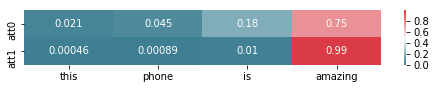

In [18]:
# Visualizing the attention layer
np.squeeze(att.asnumpy(), 0).shape
plt.figure(figsize=(8,1))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(np.squeeze(att.asnumpy(), 0), cmap=cmap, annot=True,
            xticklabels=['this','phone','is','amazing'], yticklabels=['att0', 'att1'])
plt.show()